# Example `Dysmalpy` 1D fitting #

**Includes the following components:**
 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

#### First import modules ####

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

##### Setup notebook #####

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [3]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

#### Set data, output paths ####

In [4]:
# Data directory
data_dir = '/Users/sedona/data/dysmalpy_example_data/'
#'/YOUR/DATA/PATH/'

# Where to save output files
#outdir  = './output_1D/'
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/'

-------------------

##### Set function to tie scale height relative to effective radius #####

In [5]:
def tie_sigz_reff(model_set):
 
    reff = model_set.components['disk+bulge'].r_eff_disk.value
    invq = model_set.components['disk+bulge'].invq_disk
    sigz = 2.0*reff/invq/2.35482

    return sigz

##### Set function to tie Mvirial to $f_{DM}(R_e)$

In [6]:
def tie_lmvirial_NFW(model_set):
    comp_halo = model_set.components.__getitem__('halo')
    comp_baryons = model_set.components.__getitem__('disk+bulge')
    r_fdm = model_set.components['disk+bulge'].r_eff_disk.value
    mvirial = comp_halo.calc_mvirial_from_fdm(comp_baryons, r_fdm, 
                    adiabatic_contract=model_set.kinematic_options.adiabatic_contract)
    return mvirial

- Also see **fitting_wrappers.utils_io** for more tied functions

----------

## Initialize galaxy, model set, instrument ##

In [7]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()
inst = instrument.Instrument()

### Baryonic component: Combined Disk+Bulge ###

In [8]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component ###

In [9]:
mvirial = 12.0
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile ###

In [10]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof')

### z-height profile ###

In [11]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry ###

In [12]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': True,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

## Add all model components to ModelSet ##

In [13]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile ###

In [14]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the instrument ###

In [15]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

## Add the model set, instrument to the Galaxy ##

In [16]:
gal.model = mod_set
gal.instrument = inst

## Load data ##

* Load the data from file:
  - *1D velocity, dispersion profiles and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data1D` class

* Add data to Galaxy object

In [17]:
f_data_1d = data_dir+'GS4_43501.obs_prof.txt'
dat_arr = np.loadtxt(f_data_1d)
gs4_r = dat_arr[:,0]
gs4_vel = dat_arr[:,1]
gs4_disp = dat_arr[:,3]
err_vel = dat_arr[:,2]
err_disp = dat_arr[:,4]
inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data1D data class: 
#    ** specifies slit width, slit PA as well **
data1d = data_classes.Data1D(r=gs4_r, velocity=gs4_vel,
                                  vel_disp=gs4_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, slit_width=beamsize.value,
                                  slit_pa=pa, inst_corr=inst_corr, 
                                  filename_velocity=f_data_1d)

# Add data to Galaxy object:
gal.data = data1d

#### Setup apertures:

In [18]:
# Setup apertures: circular apertures placed on the cube for GS4_43501.

profile1d_type = 'circ_ap_cube'    # Extraction in circular apertures placed on the cube

aperture_radius = 0.5 * gal.instrument.beam.major.value

moment_calc  = False    # 1D data was extracted using Gaussian fits

gal.data.apertures = aperture_classes.setup_aperture_types(gal=gal, 
                profile1d_type=profile1d_type, 
                aperture_radius=aperture_radius, 
                from_data=True, 
                partial_weight=True,
                moment=moment_calc)

# Add profile1d_type to data:
gal.data.profile1d_type = profile1d_type

-----------------

# MPFIT Fitting #

## MPFIT fitting parameters: ##

In [19]:
# Options passed to MPFIT:
maxiter = 200

# Other options:
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

outdir_mpfit = outdir+'MPFIT/'

# Choose plot filetype:
plot_type = 'png'

## Run `Dysmalpy` fitting: MPFIT ##

In [20]:
mpfit_results = fitting.fit_mpfit(gal, oversample=oversample,
                                        fitdispersion=fitdispersion,
                                        profile1d_type=gal.data.profile1d_type,
                                        maxiter=maxiter,
                                        do_plotting=do_plotting,
                                        outdir=outdir_mpfit,
                                        plot_type=plot_type)

INFO:DysmalPy:Making path=/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/MPFIT/
INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:    velocity file: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a1a122950>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
MPFIT Fitting:
Start: 2020-10-18 00:15:04.748657

INFO:DysmalPy:Iter 1  CHI-SQUARE = 1335.146297  DOF = 32
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 5  
   halo:fdm = 0.5  
   dispprof:sigma0 = 39  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 92.45642108  DOF = 32
   disk+bulge:total_mass = 10.7376182  
   disk+bulge:r_eff_disk = 3.193570965  
   halo:fdm = 0.3338865341  
   dispprof:sigma0 = 45.13124411  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 60.37634696  DOF = 32
   disk+bulge:total_mass = 10.68463857  
   disk+bulge:r_eff_disk = 2.961076539  
   halo:fdm = 0.2934130551  
   dispp

## Examine MPFIT results ##

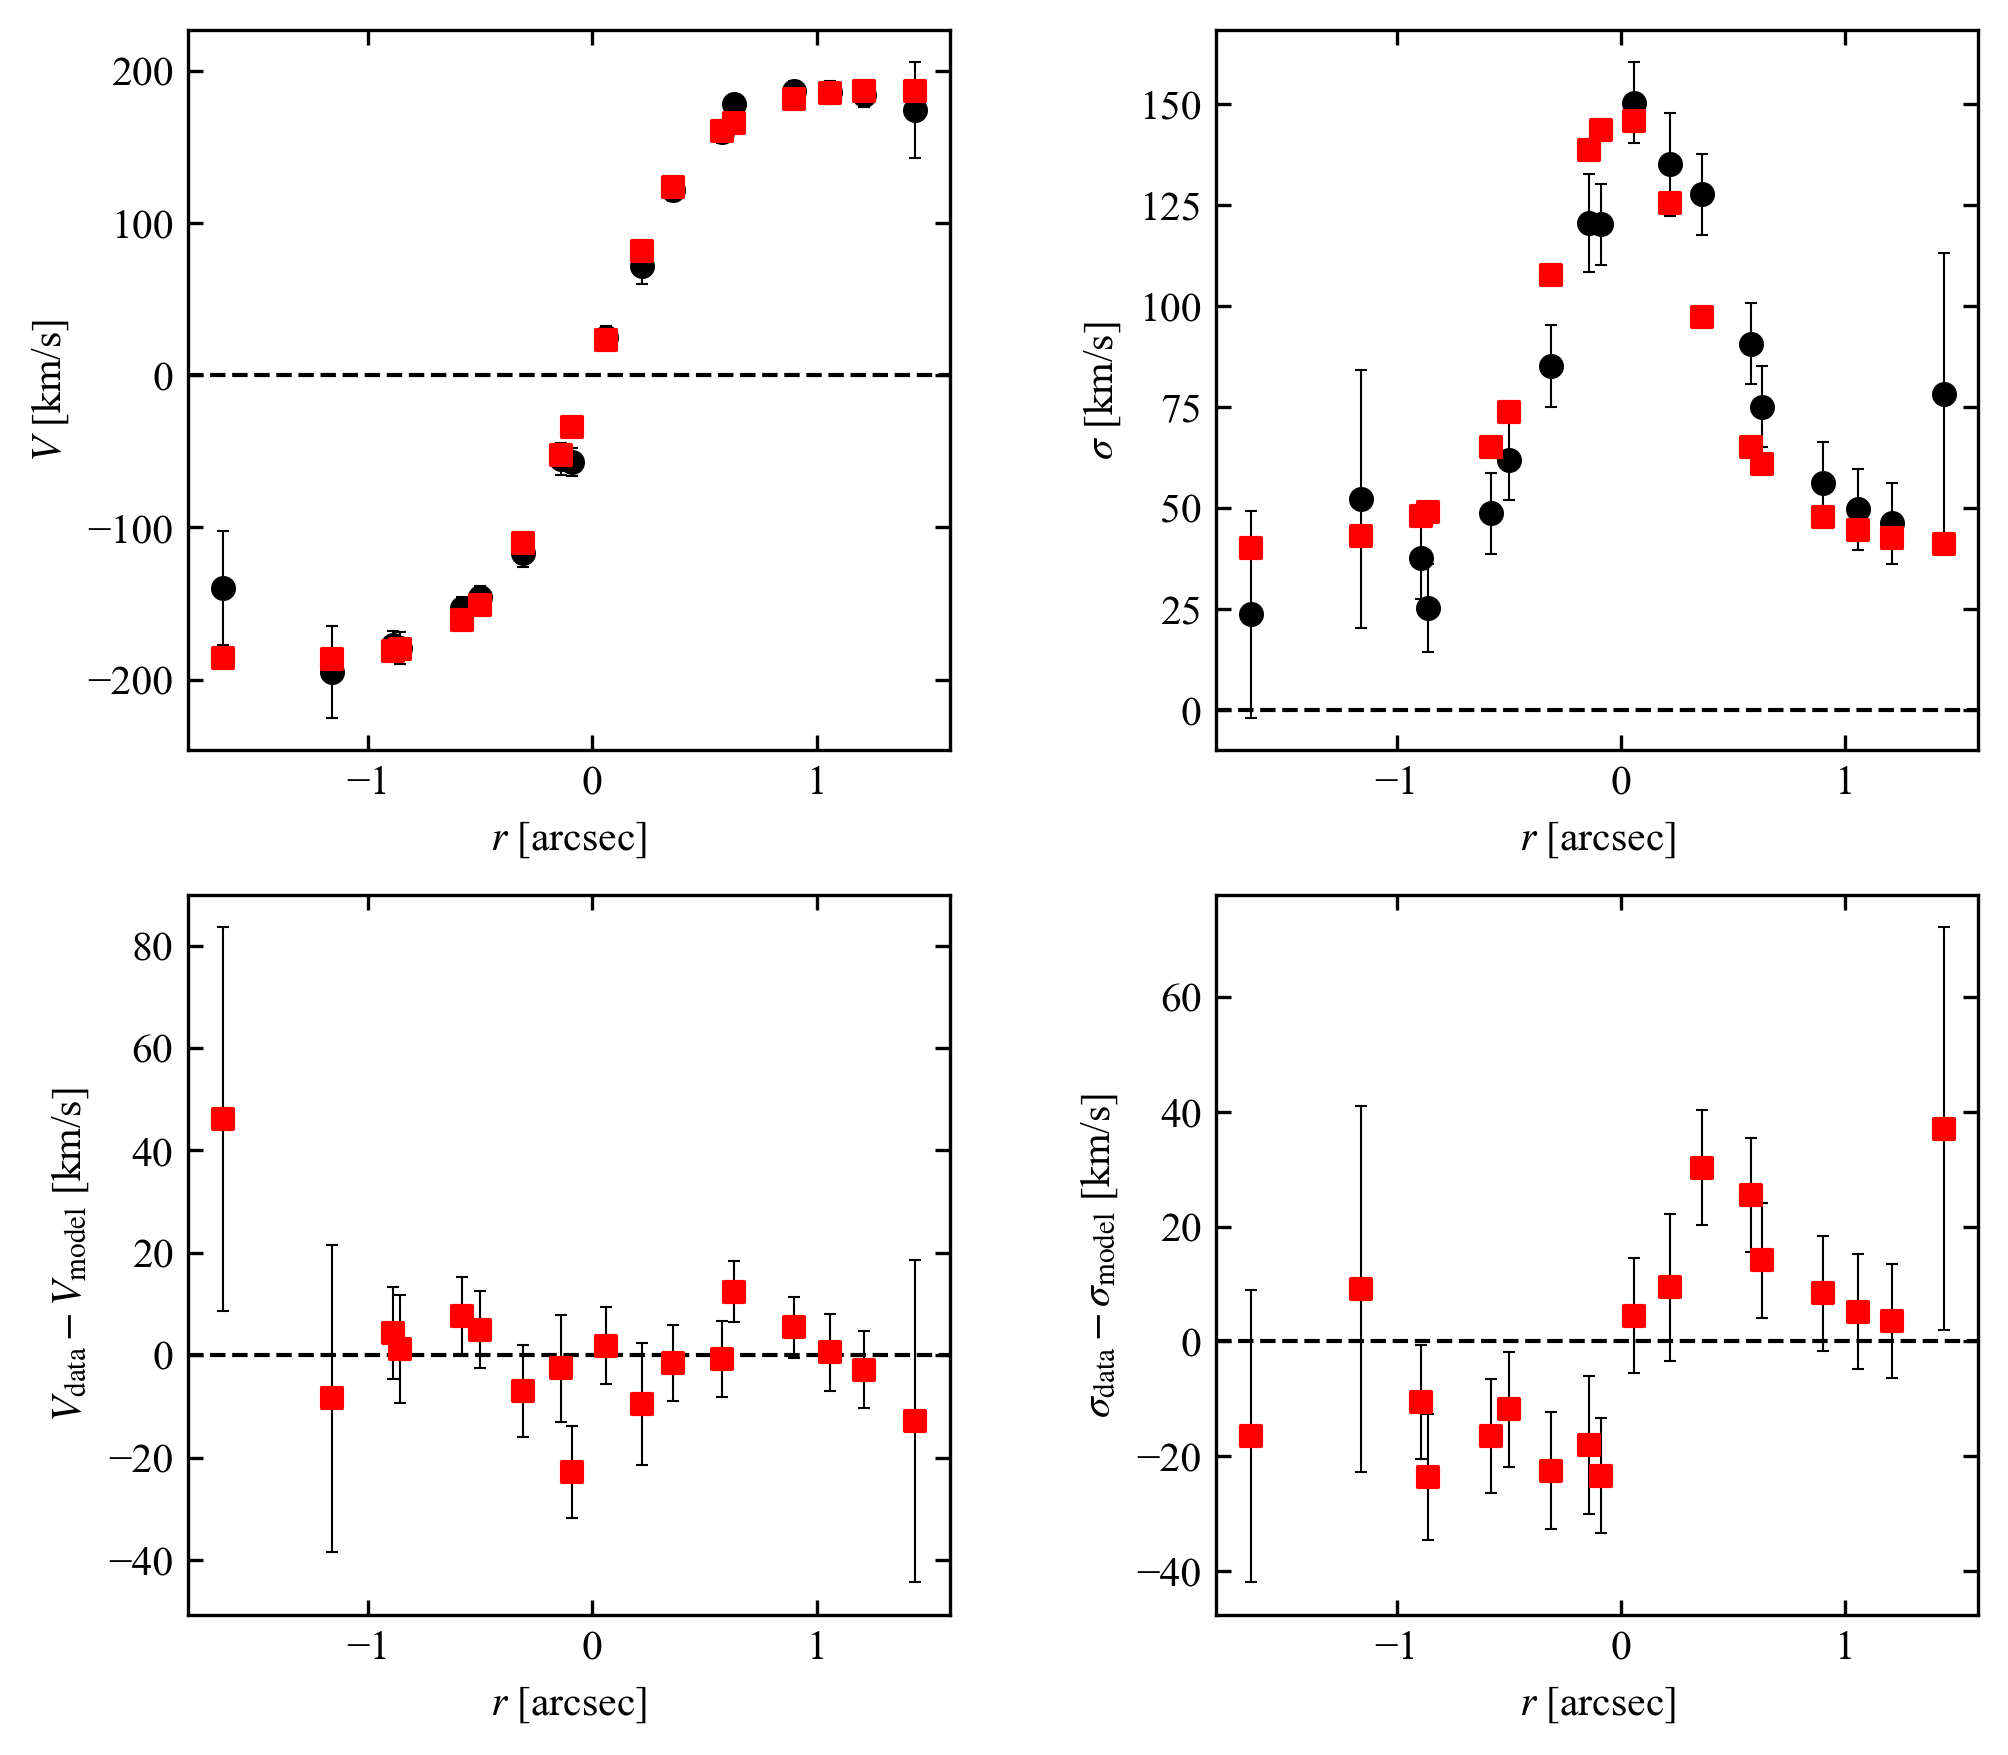

In [21]:
# Look at best-fit:
filepath = outdir_mpfit+"mpfit_best_fit.{}".format(plot_type)
Image(filename=filepath, width=600, height=570)

#### Reload the galaxy, results files:

In [22]:
f_galmodel =       outdir_mpfit + 'galaxy_model.pickle'
f_mpfit_results =  outdir_mpfit + 'mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting_mpfit(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results)

#### Plot the best-fit results:

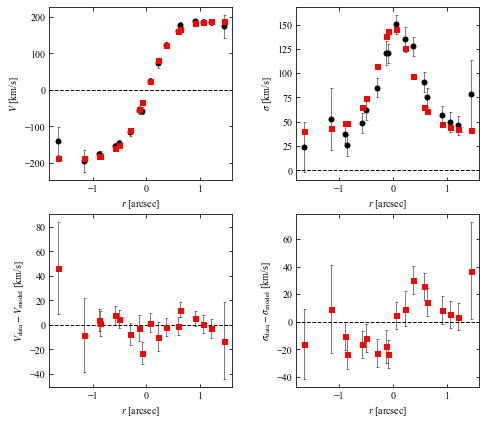

In [23]:
mpfit_results.plot_results(gal, fitdispersion=fitdispersion, 
                              oversample=oversample, 
                              f_plot_bestfit=None)

### Print results report:

In [24]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-18 00:15:25.268736

Datafile: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt

Fitting method: MPFIT

profile1d_type: circ_ap_cube
moment_calc: False
partial_weight: True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.6801  +/-   0.0401
    r_eff_disk        2.8897  +/-   0.3326

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.2832  +/-   0.0478

    mvirial          12.4925  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           38.6927  +/-   4.3020
-----------
 zheightgaus
    sigmaz            0.4909  [TIED]
-----------
 geom
    inc              62.0000  [FIXED]
    pa              142.0000  [FIXED]
    xshift            0.0000  [FIXED]
    yshif

### Or save results report to file:

In [25]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

# MCMC Fitting #

##### Get a clean copy of model, instrument

In [26]:
gal.model = copy.deepcopy(mod_set)
gal.instrument = copy.deepcopy(inst)

### MCMC fitting parameters ###

Set parameters for fitting: 
   - Passing options to `emcee`
   - Other calculation options

In [27]:
# Options passed to emcee
nwalkers = 1000
ncpus = 4
scale_param_a = 3
nburn = 50
nsteps = 200
minaf = None
maxaf = None
neff = 10

# nwalkers = 500
# ncpus = 4
# scale_param_a = 3
# nburn = 50
# nsteps = 50
# minaf = None
# maxaf = None
# neff = 10

# # SHORT TEST:
# nwalkers = 20
# ncpus = 4
# scale_param_a = 3
# nburn = 2
# nsteps = 5
# minaf = None
# maxaf = None
# neff = 10

# Other options
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step

outdir_mcmc = outdir + 'MCMC/'

# Choose plot filetype:
plot_type = 'png'

-------

## Run `Dysmalpy` fitting: MCMC ##

In [28]:
gal.model.components['zheightgaus'].sigmaz.tied 

<function __main__.tie_sigz_reff(model_set)>

In [29]:
mcmc_results = fitting.fit(gal, nWalkers=nwalkers, nCPUs=ncpus,
                               scale_param_a=scale_param_a, nBurn=nburn,
                               nSteps=nsteps, minAF=minaf, maxAF=maxaf,
                               nEff=neff, do_plotting=do_plotting,
                               oversample=oversample, outdir=outdir_mcmc,
                               fitdispersion=fitdispersion,
                               profile1d_type=gal.data.profile1d_type,
                               blob_name=blob_name, 
                               plot_type=plot_type)

INFO:DysmalPy:Making path=/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/MCMC/
INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:    velocity file: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 1000
INFO:DysmalPy:lnlike: red_chisq=False
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1a1a122950>
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
Burn-in:
Start: 2020-10-18 00:15:25.453280

INFO:DysmalPy: k=0, time.time=2020-10-18 00:15:25.454317, a_frac=nan
INFO:DysmalPy: k=1, time.time=2020-10-18 00:20:09.333325, a_frac=0.295
INFO:DysmalPy: k=2, time.time=2020-10-18 00:21:52.703392, a_frac=0.301
INFO:DysmalPy: k=3, time.time=2020-10-18 00:23:40.479206, a_frac=0.29966666666666664
INFO:DysmalPy: k=4, time.time=2020-10-18 00:25:30.563967, a_frac=0.29375
INFO:DysmalPy: k=5, 

INFO:DysmalPy:ii=23, a_frac=0.3514583333333334 time.time()=2020-10-18 03:16:38.209103
INFO:DysmalPy: 23: Chain too short for acor to run
INFO:DysmalPy:ii=24, a_frac=0.35296000000000005 time.time()=2020-10-18 03:19:21.325714
INFO:DysmalPy: 24: Chain too short for acor to run
INFO:DysmalPy:ii=25, a_frac=0.3530384615384615 time.time()=2020-10-18 03:22:02.166321
INFO:DysmalPy: 25: Chain too short for acor to run
INFO:DysmalPy:ii=26, a_frac=0.35377777777777775 time.time()=2020-10-18 03:24:41.442487
INFO:DysmalPy: 26: Chain too short for acor to run
INFO:DysmalPy:ii=27, a_frac=0.3545 time.time()=2020-10-18 03:27:23.402747
INFO:DysmalPy: 27: Chain too short for acor to run
INFO:DysmalPy:ii=28, a_frac=0.35555172413793107 time.time()=2020-10-18 03:30:05.172553
INFO:DysmalPy: 28: Chain too short for acor to run
INFO:DysmalPy:ii=29, a_frac=0.3554666666666667 time.time()=2020-10-18 03:32:42.358898
INFO:DysmalPy: 29: Chain too short for acor to run
INFO:DysmalPy:ii=30, a_frac=0.3560322580645161 tim

INFO:DysmalPy: 83: Chain too short for acor to run
INFO:DysmalPy:ii=84, a_frac=0.35876470588235293 time.time()=2020-10-18 06:39:33.008000
INFO:DysmalPy: 84: Chain too short for acor to run
INFO:DysmalPy:ii=85, a_frac=0.3589418604651162 time.time()=2020-10-18 06:43:51.310187
INFO:DysmalPy: 85: Chain too short for acor to run
INFO:DysmalPy:ii=86, a_frac=0.35874712643678164 time.time()=2020-10-18 06:48:20.328695
INFO:DysmalPy: 86: Chain too short for acor to run
INFO:DysmalPy:ii=87, a_frac=0.35867045454545454 time.time()=2020-10-18 06:52:50.806707
INFO:DysmalPy: 87: Chain too short for acor to run
INFO:DysmalPy:ii=88, a_frac=0.3588988764044943 time.time()=2020-10-18 06:57:11.992178
INFO:DysmalPy: 88: Chain too short for acor to run
INFO:DysmalPy:ii=89, a_frac=0.35906666666666665 time.time()=2020-10-18 07:01:44.770116
INFO:DysmalPy: 89: Chain too short for acor to run
INFO:DysmalPy:ii=90, a_frac=0.35923076923076924 time.time()=2020-10-18 07:06:17.690201
INFO:DysmalPy: 90: Chain too short f

INFO:DysmalPy:ii=143, a_frac=0.35725694444444445 time.time()=2020-10-18 10:56:12.505014
INFO:DysmalPy: 143: Chain too short for acor to run
INFO:DysmalPy:ii=144, a_frac=0.357048275862069 time.time()=2020-10-18 11:00:45.703184
INFO:DysmalPy: 144: Chain too short for acor to run
INFO:DysmalPy:ii=145, a_frac=0.3571712328767123 time.time()=2020-10-18 11:05:17.206457
INFO:DysmalPy: 145: Chain too short for acor to run
INFO:DysmalPy:ii=146, a_frac=0.3571292517006802 time.time()=2020-10-18 11:09:10.360474
INFO:DysmalPy: 146: Chain too short for acor to run
INFO:DysmalPy:ii=147, a_frac=0.3571554054054054 time.time()=2020-10-18 11:13:15.414929
INFO:DysmalPy: 147: Chain too short for acor to run
INFO:DysmalPy:ii=148, a_frac=0.35718791946308726 time.time()=2020-10-18 11:17:51.415588
INFO:DysmalPy: 148: Chain too short for acor to run
INFO:DysmalPy:ii=149, a_frac=0.35712666666666665 time.time()=2020-10-18 11:22:20.166785
INFO:DysmalPy: 149: Chain too short for acor to run
INFO:DysmalPy:ii=150, a_f

## Examine MCMC results ##

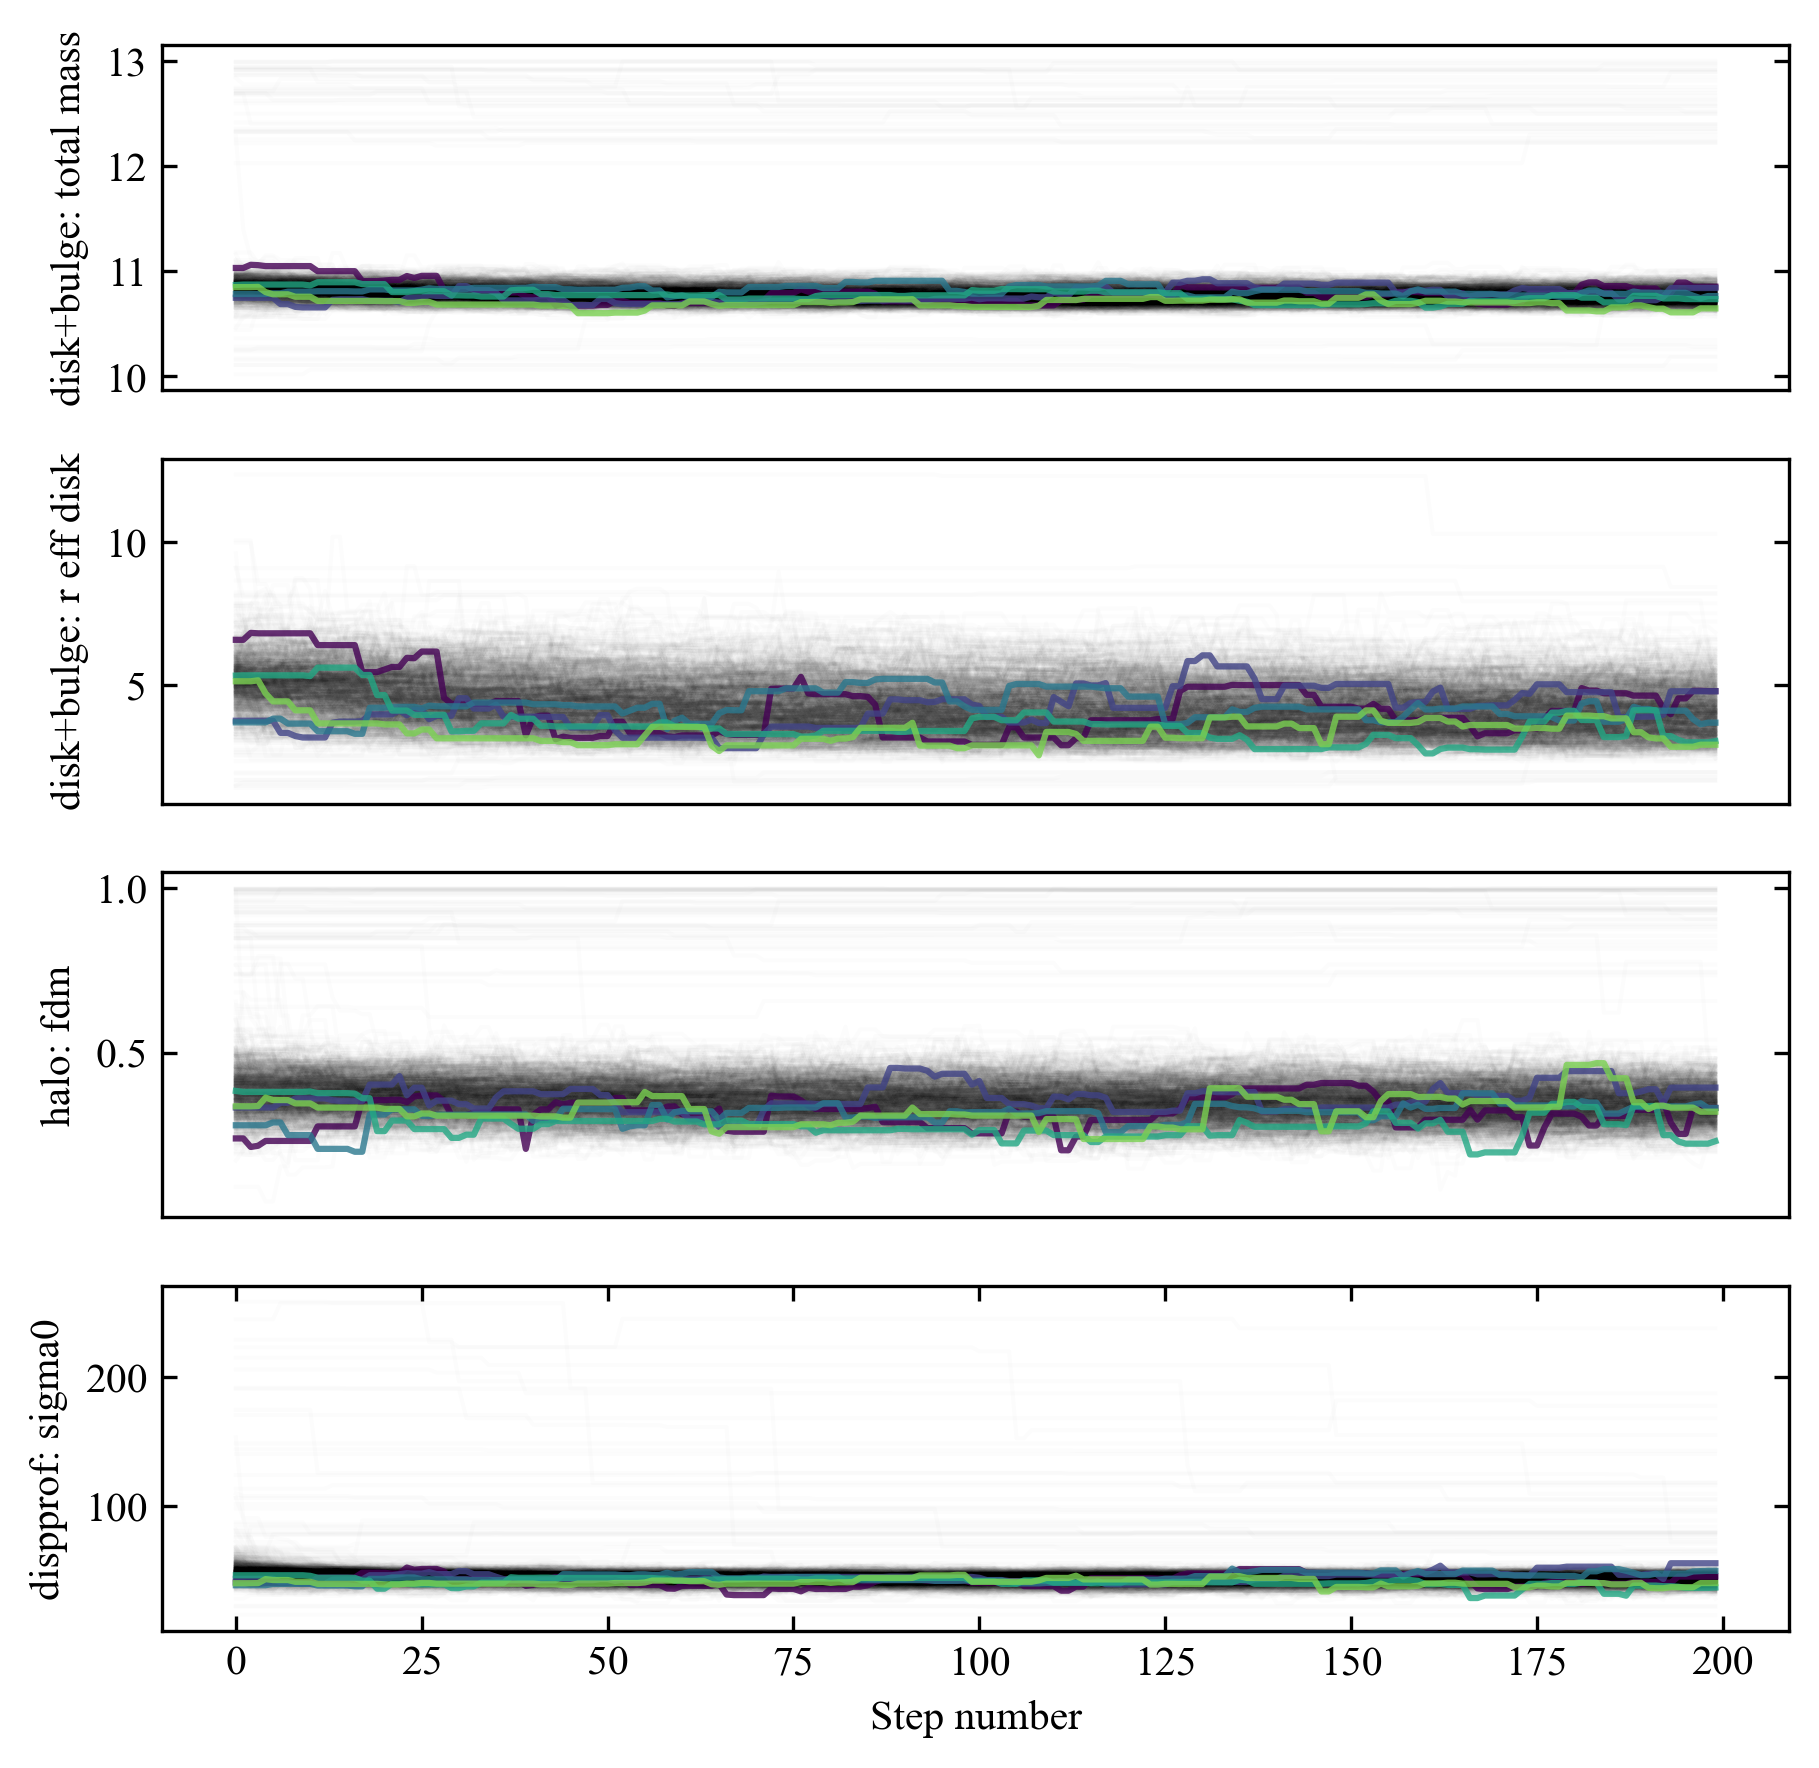

In [30]:
# Look at trace:
filepath = outdir_mcmc+"mcmc_trace.{}".format(plot_type)
Image(filepath, width=600, height=400)

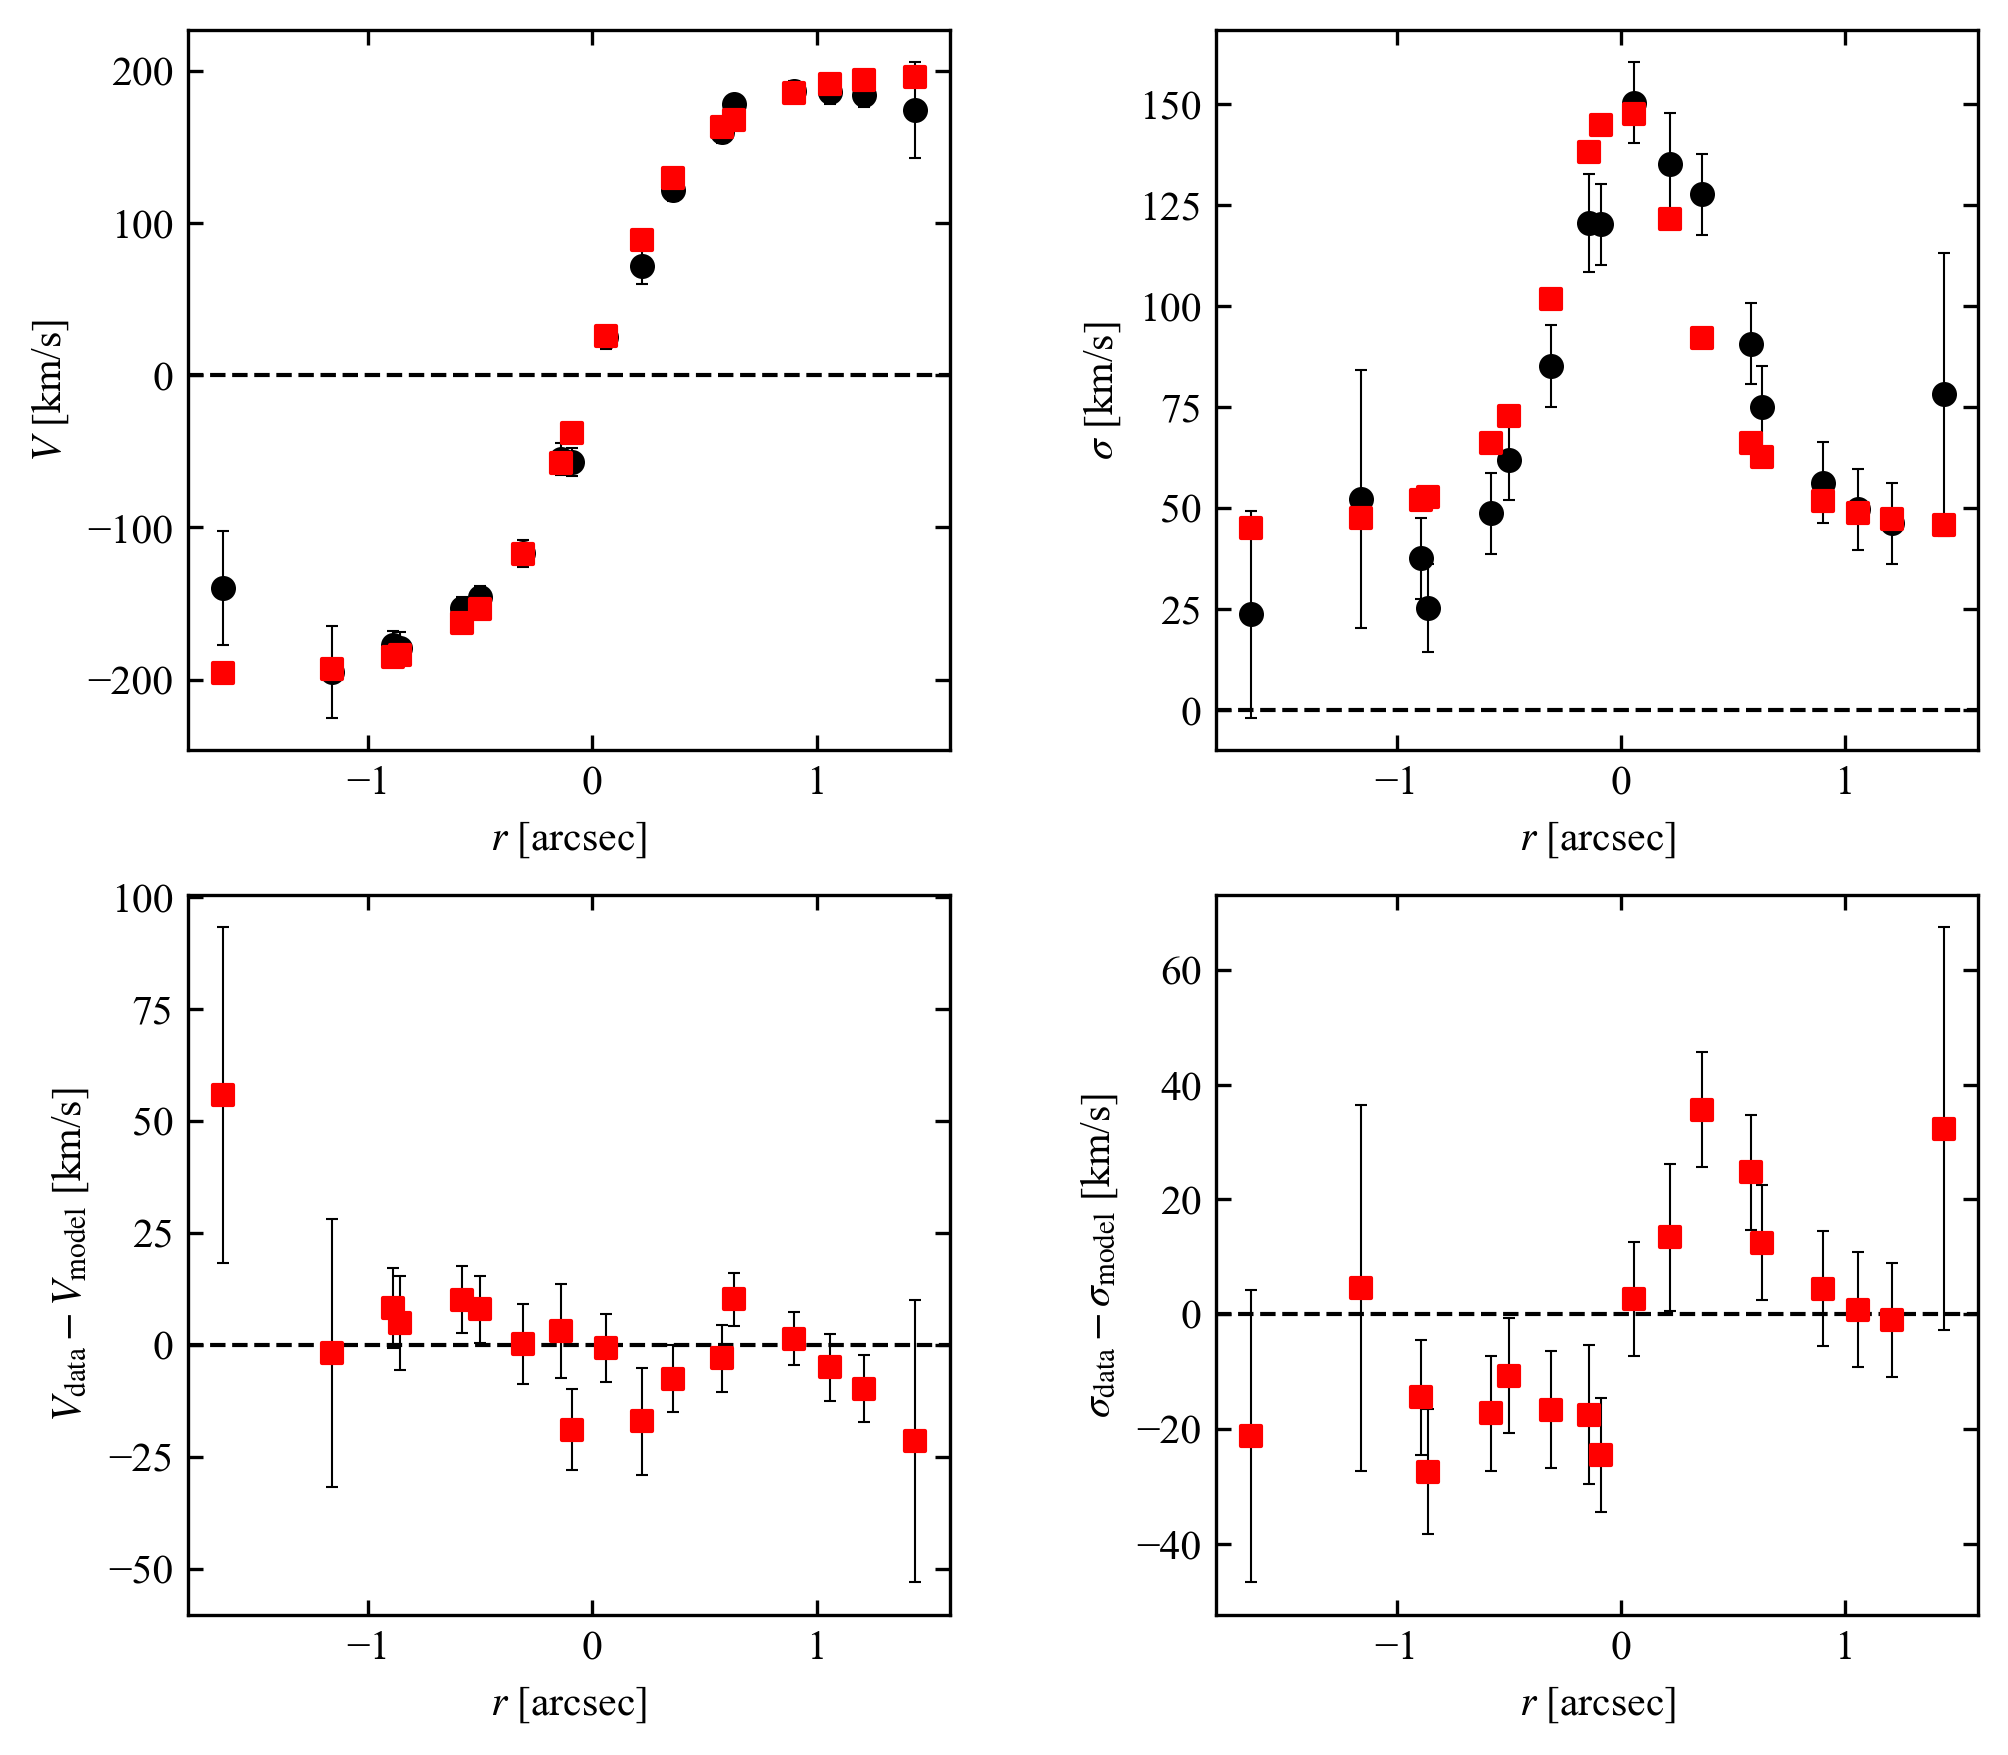

In [31]:
# Look at best-fit:
filepath = outdir_mcmc+"mcmc_best_fit.{}".format(plot_type)
Image(filepath, width=600, height=570)

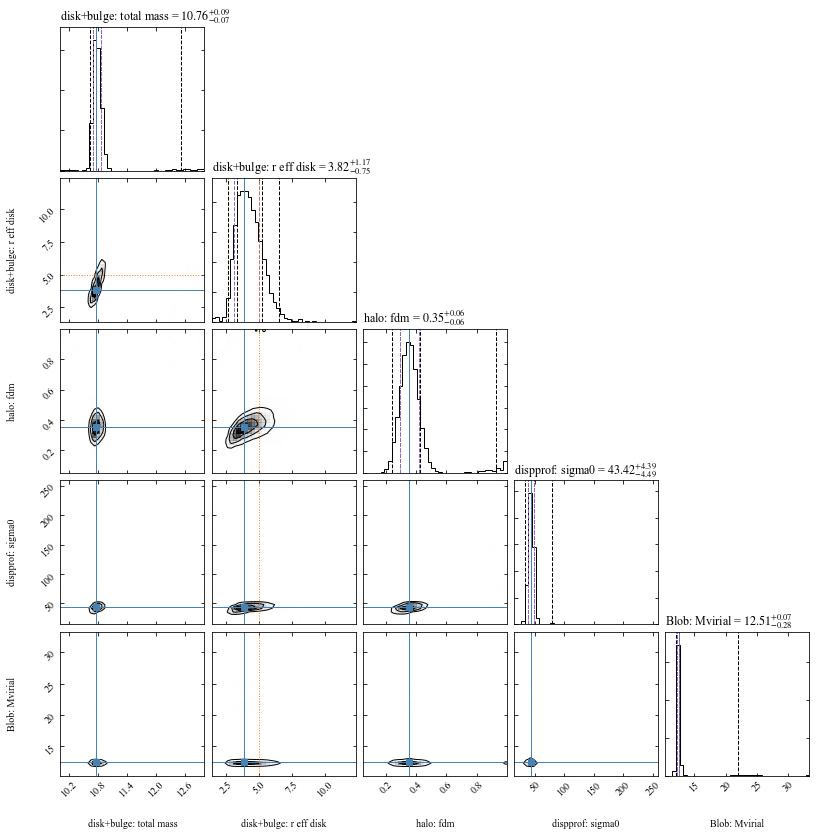

In [32]:
# Look at corner:
filepath = outdir_mcmc+"mcmc_param_corner.{}".format(plot_type)
Image(filepath, width=570, height=620)

---------

## Load and examine results: ##

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

#### Reload the galaxy, results files:

In [33]:
f_galmodel =      outdir_mcmc + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc + 'mcmc_results.pickle'

gal, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_mcmc_results=f_mcmc_results)

#### If necessary, also reload the sampler chain:

In [34]:
f_sampler =  outdir_mcmc + 'mcmc_sampler.pickle'
mcmc_results.reload_sampler(filename=f_sampler)

#### Plot the best-fit results:

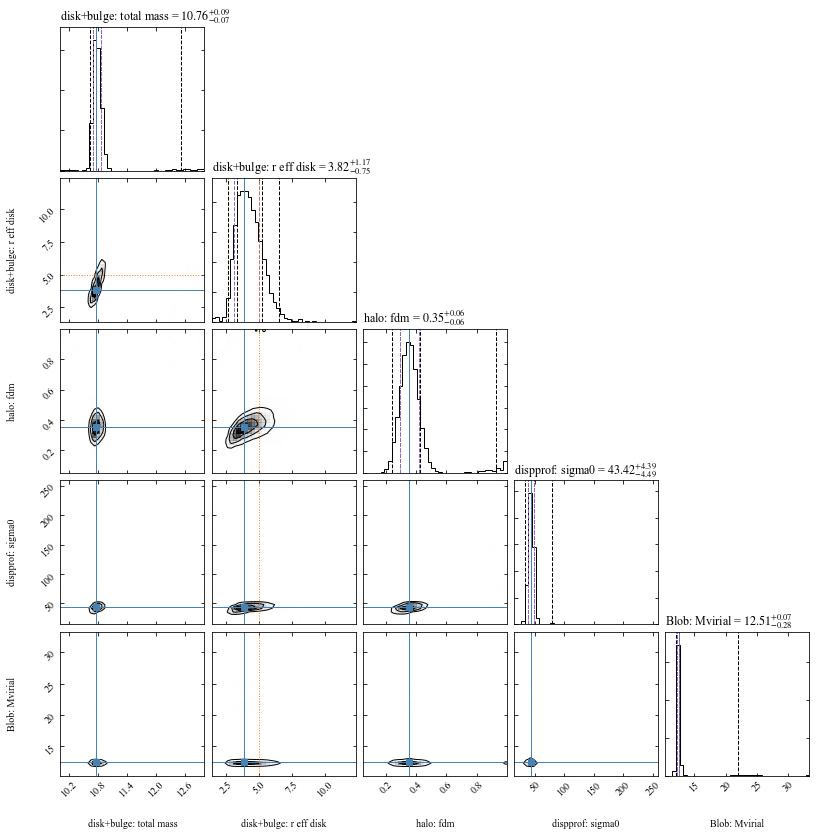

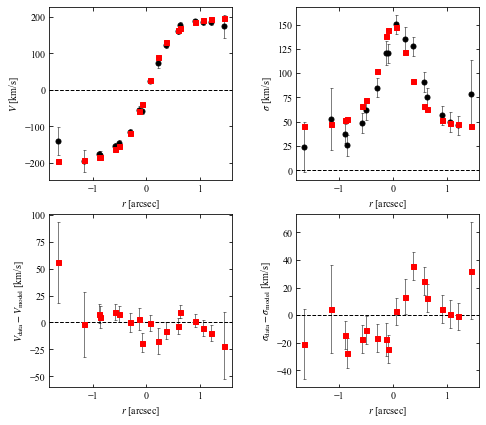

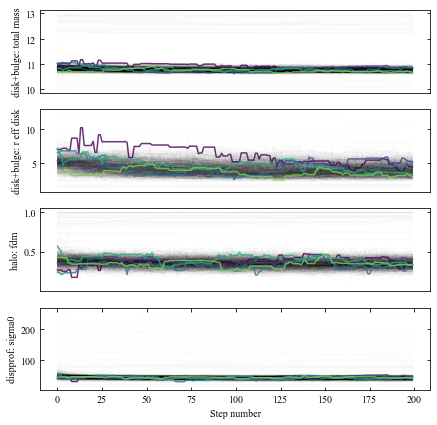

In [35]:
mcmc_results.plot_results(gal, fitdispersion=fitdispersion, 
                          oversample=oversample, 
                          f_plot_param_corner=None, 
                          f_plot_bestfit=None, f_plot_trace=None)

### Print results report:

In [36]:
# Print report
print(mcmc_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2020-10-18 15:06:07.429692

Datafile: /Users/sedona/data/dysmalpy_example_data/GS4_43501.obs_prof.txt

Fitting method: MCMC

profile1d_type: circ_ap_cube
moment_calc: False
partial_weight: True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass       10.7580  -   0.0735 +   0.0928
    r_eff_disk        3.8238  -   0.7459 +   1.1662

    n_disk            1.0000  [FIXED]
    r_eff_bulge       1.0000  [FIXED]
    n_bulge           4.0000  [FIXED]
    bt                0.3000  [FIXED]
-----------
 halo
    fdm               0.3546  -   0.0625 +   0.0647

    mvirial          12.5129  [TIED]
    conc              5.0000  [FIXED]
-----------
 dispprof
    sigma0           43.4196  -   4.4884 +   4.3869
-----------
 zheightgaus
    sigmaz            0.6495  [TIED]
-----------
 geom
    inc              62.0000  [FIXED]
    pa              142.0000  [FIXED]
    xshift  

### Or save results report to file:

In [37]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
mcmc_results.results_report(gal=gal, filename=f_mcmc_report)

------